In [1]:
import os
import sys
sys.path.extend(["../..", "."])

from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, "..", "..")

from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import get_model_rocs, allign_metrics, report_alligned_metrics, get_roc
from nebula.misc.plots import plot_roc_curve, plot_cv_metrics_dict, plot_losses
from nebula.models.neurlux import NeurLuxModel
from nebula.models.quovadis import QuoVadisModel
from nebula.models import TransformerEncoderChunks
from collections import defaultdict
import numpy as np
import pickle
import json
import torch

RUN_TYPES = ["nebula", "neurlux", "quovadis"]
RUN_NAME = "speakeasy"

INFOLDER = "out_speakeasy"

RUN_END_FILTER = "r1763_t20"
run_folders = [x for x in os.listdir(INFOLDER) if x.startswith("cv") and x.endswith(RUN_END_FILTER)]

VOCAB = 50000
SEQ_LEN = 512


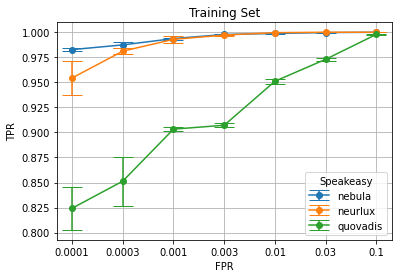

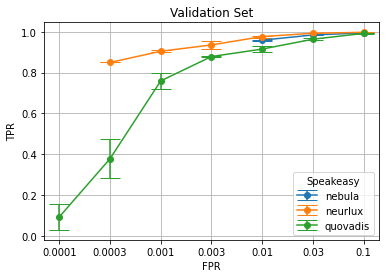

In [2]:
def training_filter(file):
    return file.endswith("training.json")
def validation_filter(file):
    return file.endswith("validation.json")
def key_extractor(file):
    return file.split("_")[0]

metrics_train = {}
metrics_val = {}
for folder in run_folders:
    metrics_train.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, training_filter))
    metrics_val.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, validation_filter))

TITLE = RUN_NAME.capitalize()
newkeys = [x for x in metrics_train.keys()]
ax = plot_cv_metrics_dict(metrics_train, "tpr", legendTitle=TITLE, legendValues=newkeys)
ax.set_title("Training Set")

ax = plot_cv_metrics_dict(metrics_val, "tpr", legendTitle=TITLE, legendValues=newkeys)
_ = ax.set_title("Validation Set")

In [3]:
models = defaultdict(dict)

neurlux_vocab_file = os.path.join(INFOLDER, f"neurlux_{RUN_NAME}_vocab_{VOCAB}_seqlen_{SEQ_LEN}", f"vocab_{VOCAB}.json")
quo_vadis_data_folder = os.path.join(INFOLDER, f"quovadis_{RUN_NAME}_vocab_{VOCAB}_seqlen_{SEQ_LEN}")
quo_vadis_vocab_name = [x for x in os.listdir(quo_vadis_data_folder) if x.startswith("vocab")][0]
quovadis_vocab_file = os.path.join(quo_vadis_data_folder, quo_vadis_vocab_name)
nebula_vocab_file = os.path.join(INFOLDER, f"nebula_{RUN_NAME}_vocab_{VOCAB}_seqlen_{SEQ_LEN}", f"tokenizer_{VOCAB}_vocab.json")

with open(neurlux_vocab_file) as f:
    neurlux_vocab = json.load(f)
models['neurlux']['class'] = NeurLuxModel
models['neurlux']['config'] = {
    "embedding_dim": 256,
    "vocab_size": len(neurlux_vocab),
    "seq_len": SEQ_LEN,
}

models['quovadis']['class'] = QuoVadisModel
models['quovadis']['config'] = {
    "vocab": quovadis_vocab_file,
    "seq_len": SEQ_LEN
}

with open(nebula_vocab_file) as f:
    nebula_vocab = json.load(f)
models['nebula']['class'] = TransformerEncoderChunks
models['nebula']['config'] = {
    "vocab_size": len(nebula_vocab),
    "maxlen": SEQ_LEN,
    "chunk_size": 64,
    "dModel": 64,  # embedding & transformer dimension
    "nHeads": 8,  # number of heads in nn.MultiheadAttention
    "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
    "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    "numClasses": 1, # binary classification
    "hiddenNeurons": [64],
    "layerNorm": False,
    "dropout": 0.3,
    "mean_over_sequence": False,
    "norm_first": True
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
existing_pickle = os.path.join(INFOLDER, f"roc_metrics_val_{RUN_END_FILTER}.pkl")
if os.path.exists(existing_pickle):
    metrics_val = pickle.load(open(existing_pickle, "rb"))
else:
    metrics_val = defaultdict(list)
    model_files = defaultdict(list)
    for folder in run_folders:
        key = folder.split("_")[1]
        print(f"[*] In process: {key}")

        folder = os.path.join(INFOLDER, folder)
        data_splits = read_cv_data_splits(folder)
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]
        
        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(
                model,
                data_splits[i]["X_test"],
                data_splits[i]["y_test"],
                model_name=f"{key}_split_{i}",
                batch_size=96,
                metrics_full=True
            )
            metrics_val[key].append([fpr, tpr, roc_auc, f1, recall, precision, acc])
    pickle.dump(metrics_val, open(existing_pickle, "wb"))

base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(metrics_val)

[*] In process: nebula
[*] Running ROC for split: 0
Evaluating nebula_split_0 | Size: 5397313...


100%|██████████| 265/265 [00:09<00:00, 29.06it/s]


[*] Running ROC for split: 1
Evaluating nebula_split_1 | Size: 5397313...


100%|██████████| 265/265 [00:08<00:00, 31.92it/s]


[*] Running ROC for split: 2
Evaluating nebula_split_2 | Size: 5397313...


100%|██████████| 265/265 [00:08<00:00, 29.73it/s]


[*] In process: neurlux
[*] Running ROC for split: 0
Evaluating neurlux_split_0 | Size: 13034745...


100%|██████████| 265/265 [00:04<00:00, 53.58it/s]


[*] Running ROC for split: 1
Evaluating neurlux_split_1 | Size: 13034745...


100%|██████████| 265/265 [00:03<00:00, 72.05it/s]


[*] Running ROC for split: 2
Evaluating neurlux_split_2 | Size: 13034745...


100%|██████████| 265/265 [00:03<00:00, 68.67it/s]


[*] In process: quovadis
[*] Running ROC for split: 0
Evaluating quovadis_split_0 | Size: 1448449...


100%|██████████| 265/265 [00:04<00:00, 59.51it/s]


[*] Running ROC for split: 1
Evaluating quovadis_split_1 | Size: 1448449...


100%|██████████| 265/265 [00:04<00:00, 59.41it/s]


[*] Running ROC for split: 2
Evaluating quovadis_split_2 | Size: 1448449...


100%|██████████| 265/265 [00:04<00:00, 58.26it/s]


,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC,F1,Recall,Precision,Accuracy
nebula,0.060283,0.373517,0.663850,0.858618,0.957496,0.983791,0.994014,0.998581,0.996680,0.984478,0.986726,0.982246,0.978969
neurlux,0.657458,0.854543,0.904398,0.935324,0.976152,0.992522,0.997085,0.999359,0.998436,0.990243,0.990030,0.990464,0.986811
quovadis,0.094050,0.378565,0.759208,0.878393,0.934558,0.965642,0.993119,0.998698,0.995413,0.974367,0.960858,0.988273,0.965833


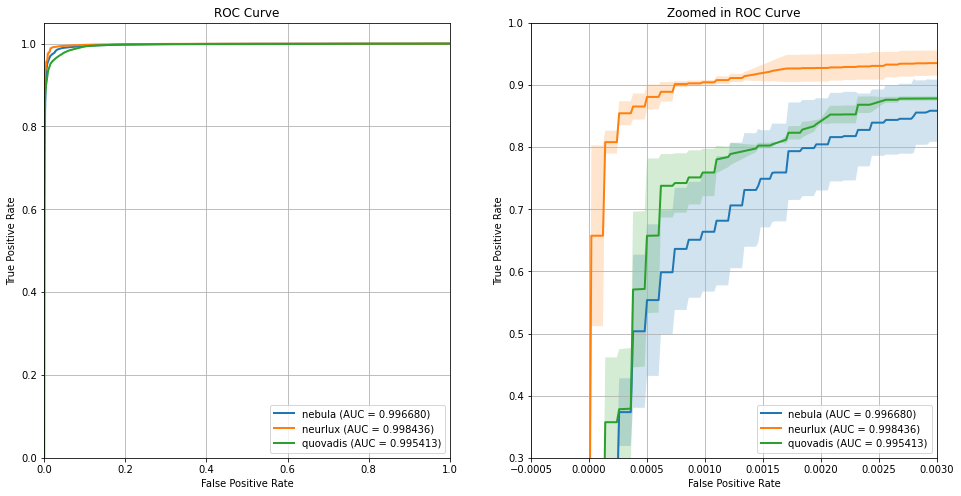

In [5]:
df, axs_val = report_alligned_metrics(
    base_fpr_val,
    tprs_mean_val,
    tprs_std_val,
    metrics_val,
    xlim=[-0.0005, 0.003],
    ylim=[0.3, 1.0],
    metrics_full=True
)
df

## Test set ROCs

In [6]:
existing_pickle = os.path.join(INFOLDER, f"roc_metrics_test_{RUN_END_FILTER}.pkl")
if os.path.exists(existing_pickle):
    metrics_test = pickle.load(open(existing_pickle, "rb"))
else:
    metrics_test = defaultdict(list)
    model_files = defaultdict(list)
    for folder in run_folders:
        key = folder.split("_")[1]
        print(f"[*] In process: {key}")
        folder = os.path.join(INFOLDER, folder)

        data_folder = [x for x in os.listdir(INFOLDER) if x.startswith(key) and "vocab" in x][0]
        X_test = np.load(os.path.join(INFOLDER, data_folder, "x_test_full.npy"))
        y_test = np.load(os.path.join(INFOLDER, data_folder, "y_test_full.npy"))

        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]

        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(
                model,
                X_test,
                y_test,
                model_name=f"{key}_split_{i}",
                batch_size=96,
                metrics_full=True
            )
            metrics_test[key].append([fpr, tpr, roc_auc, f1, recall, precision, acc])
    pickle.dump(metrics_test, open(existing_pickle, "wb"))

base_fpr_test, tprs_mean_test, tprs_std_test = allign_metrics(metrics_test)

,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,AUC,F1,Recall,Precision,Accuracy
nebula,0.112375,0.263178,0.424120,0.594633,0.739409,0.817434,0.905598,0.963912,0.965727,0.905441,0.860435,0.955772,0.903028
neurlux,0.386841,0.495353,0.538871,0.623879,0.716970,0.822078,0.927257,0.978899,0.972825,0.896339,0.840051,0.965240,0.896727
quovadis,0.086355,0.213903,0.247651,0.297884,0.486405,0.618619,0.808521,0.957784,0.926685,0.818047,0.715871,0.954338,0.827924


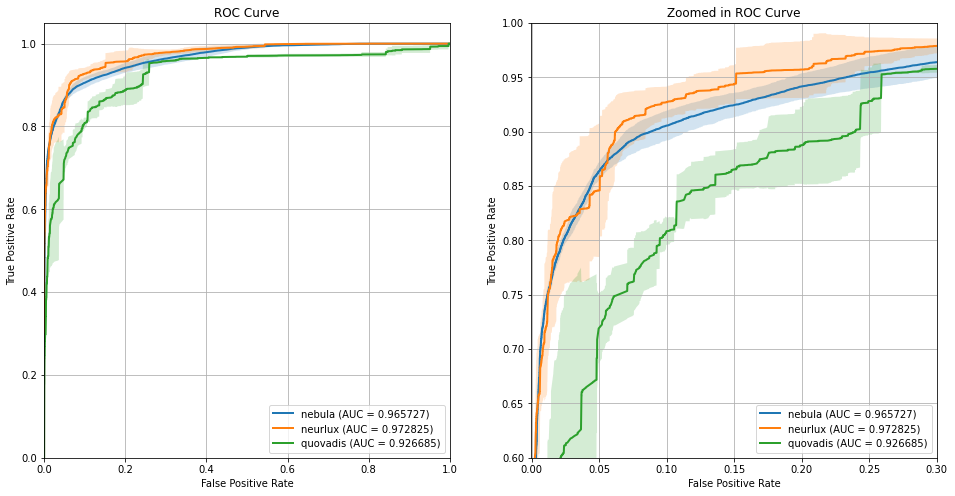

In [7]:
df, axs_test = report_alligned_metrics(
    base_fpr_test,
    tprs_mean_test,
    tprs_std_test,
    metrics_test,
    metrics_full=True
)
df

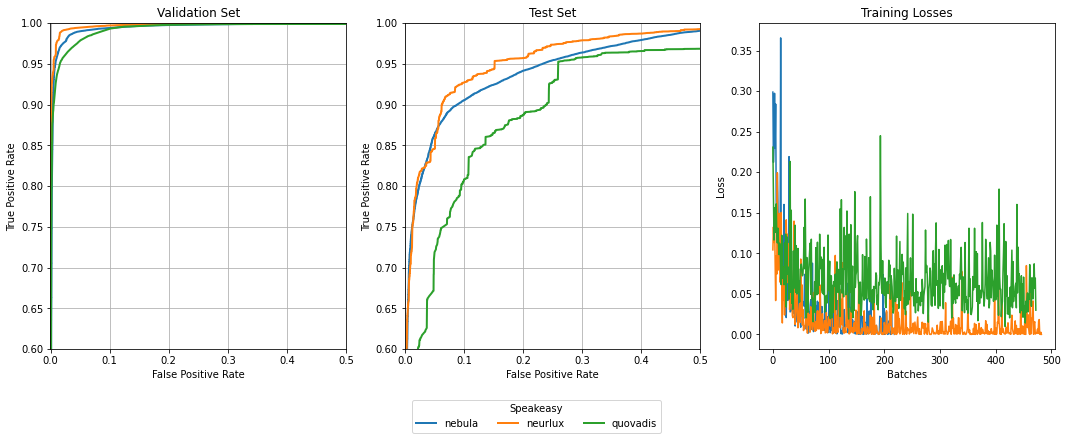

In [8]:
import matplotlib.pyplot as plt

YLIM = [0.6, 1]
XLIM = [-0.0005, 0.5]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for key in tprs_mean_val:
    if key == 0.01:
        continue
    plot_roc_curve(base_fpr_val, tprs_mean_val[key], model_name=key, ax=axs[0], ylim=YLIM, xlim=XLIM)
    plot_roc_curve(base_fpr_test, tprs_mean_test[key], model_name=key, ax=axs[1], ylim=YLIM, xlim=XLIM)

axs[0].set_title("Validation Set")
axs[1].set_title("Test Set")
#[ax.legend(loc="lower right", title="Learning rate") for ax in axs[0:2]]
[ax.set_ylabel("True Positive Rate") for ax in axs[0:2]]
[ax.set_xlabel("False Positive Rate") for ax in axs[0:2]]
[ax.grid() for ax in axs[0:2]]

start = 200
n = 50
for folder in run_folders:
    key = folder.split("_")[1]
    train_folder = os.path.join(INFOLDER, folder, "training_files")
    train_losses = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if "trainLosses" in x][0]
    loss_mean = np.load(train_losses)[start::n]    
    axs[2].plot(loss_mean, label=key)
axs[2].set_xlabel("Batches")
axs[2].set_ylabel("Loss")
axs[2].set_title("Training Losses")

# make one common legend below the plots so it does not overlap with the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, title=RUN_NAME.capitalize(), bbox_to_anchor=(0.5, -0.08))

_ = fig.savefig(os.path.join(REPO_ROOT, "img", f"results_{'_'.join(RUN_NAME.split(' '))}.png"), dpi=300, bbox_inches='tight')